#**Imports**#

In [ ]:
!pip install jsonlines

In [ ]:
#test device
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import jsonlines

import pandas as pd
import numpy as np

from typing import Tuple, List, Dict, Optional
from collections import Counter, defaultdict

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, RMSprop

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import string
import re

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
!rm -rf sample_data
!mkdir data

In [ ]:
%cd data

/content/data/data


In [ ]:
#directory to save checkpoints and path to it
root_folder = '/content/data/' 
!mkdir output_folder
PATH_OUTPUT_FOLDER = os.path.join(root_folder, 'output_folder/')

In [ ]:
#get data
!git clone https://github.com/SapienzaNLP/nlp2021-hw1/

Cloning into 'nlp2021-hw1'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 11), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
#datasets
train_path = 'nlp2021-hw1/data/train.jsonl'
dev_path = 'nlp2021-hw1/data/dev.jsonl'

In [ ]:
#borrowed from evaluation.py function to read datasets the same format as during testing
def read_dataset(path: str) -> Tuple[List[Dict], List[str]]:

    sentence_pairs = []
    labels = []

    with jsonlines.open(path) as f:
        for obj in f:
            labels.append(obj.pop('label'))
            sentence_pairs.append(obj)

    assert len(sentence_pairs) == len(labels)

    return sentence_pairs, labels

In [ ]:
#auxiliary function to check labels distribution (does not influence on the solution, just a part of data exploration)
def draw_labels(dataset_path: str, mode: str) -> None:

    _, labels = read_dataset(dataset_path)

    fig = plt.figure(figsize=(5, 5))
    
    classes = 'True', 'False'

    counter = Counter(labels)
    print('{}: '.format(mode), dict(counter))

    sizes = [counter['True'], counter['False']]

    plt.pie(sizes, labels=classes, autopct='%1.1f%%', shadow=True, startangle=90)

    plt.axis('equal')
    fig.savefig('{}.png'.format(mode),  dpi=fig.dpi)

    plt.show()


Train:  {'False': 4000, 'True': 4000}


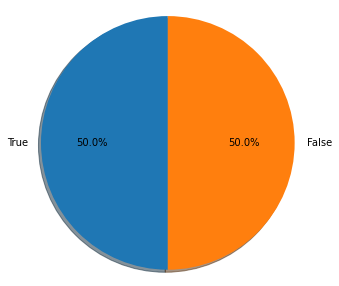

Dev:  {'False': 500, 'True': 500}


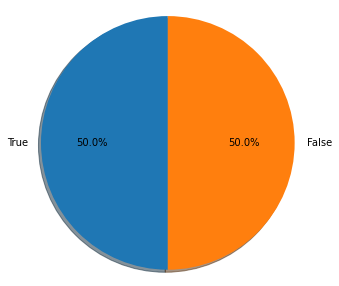

In [ ]:
draw_labels(train_path, 'Train')
draw_labels(dev_path, 'Dev')

In [ ]:
#get GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
#tried with 100d, 200d, 300d, finally 50d are chosen
!rm glove.6B.100d.txt
!rm glove.6B.200d.txt
!rm glove.6B.300d.txt
!rm glove.6B.zip

--2021-07-18 12:46:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-18 12:46:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-18 12:46:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#fix chosen dimension
n_embedding = 50

In [ ]:
#dictionary maps words to their embedded representations from Glove
word_vectors = dict()
with open('glove.6B.50d.txt') as f:

    for i, line in tqdm(enumerate(f)):

        word, *vector = line.strip().split(' ')

        vector = torch.tensor([float(c) for c in vector])
        
        word_vectors[word] = vector

#**Preprocessing**#

In [ ]:
#responsible for the preprocessong function
def sentence2vector(sentence: str, start_idx: str, end_idx: str) -> Optional[torch.Tensor]:

    # extract target word to delete it from stop words set (and to do some other experiments, but there obly for stop words set)
    target_word = sentence[int(start_idx): int(end_idx)]
    # hypthen handling, example of issue: sample 322 in train dataset, sentence 2
    cleaned_sentence = re.sub('-', ' ', sentence)
    # slash handling, example of issue: sample 1987 in train dataset, sentence 2
    cleaned_sentence = re.sub('/', ' ', cleaned_sentence)
    # dash handling, example of issue: sample 7026 in train dataset, sentence 2
    cleaned_sentence = re.sub('—', ' ', cleaned_sentence)
    # numbers removal
    unnumbered_sentence = re.sub(r'\d+', '', cleaned_sentence)
    # punctuation removal
    cleaned_sentence = unnumbered_sentence.translate(str.maketrans('', '', string.punctuation))
    # lowercasing
    lowered_sentence = cleaned_sentence.lower()
    # tokenizing
    word_tokens = word_tokenize(lowered_sentence)
    # lemmatization did not show to be advanatgeous for this apptoach
    '''lemmatized_sentence = [lemmatizer.lemmatize(word) for word in word_tokens] '''
    # stop words removal
    stop_words = set(stopwords.words('english'))
    # exception for the target words containing in the stop words set, e.g. only
    if target_word in stop_words:
        stop_words.remove(target_word)
    filtered_sentence = [word for word in word_tokens if not word in stop_words]
    # get embeddings for each word if it exists in vocabulary
    sentence_word_vector = [word_vectors[w] for w in filtered_sentence if w in word_vectors]
    if len(sentence_word_vector) == 0:
        return None
    sentence_word_vector = torch.stack(sentence_word_vector)
    # mean of embeddings for the whole sentence
    return torch.mean(sentence_word_vector, dim=0)

In [ ]:
#to join separately preprocessed sentences in a single input to a model
def concatenate(sentence1: str, start1: str, end1: str, sentence2: str, start2: str, end2: str) -> Optional[torch.Tensor]:
    # mean embedding for the sentence 1
    mean_embedding1 = sentence2vector(sentence1, start1, end1)
    # mean embedding for the sentence 2
    mean_embedding2 = sentence2vector(sentence2, start2, end2)
    # add separator and concatenate
    return torch.cat([mean_embedding1, word_vectors['.'], mean_embedding2])
    #check influence of the presence of a separator
    '''return torch.cat([mean_embedding1, mean_embedding2])'''

#**Dataset**#

In [ ]:
#Dataset class
class WiCDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str, concatenate):
        self.data_store = []
        self.init_structures(dataset_path, concatenate)

    def init_structures(self, dataset_path: str, concatenate) -> None:

        sentence_pairs, labels = read_dataset(dataset_path)

        for i, d in enumerate(sentence_pairs):

          # extract relevant fields from the input dictionaries
          sentence1 = d['sentence1']
          start1 = d['start1']
          end1 = d['end1']

          sentence2 = d['sentence2']
          start2 = d['start2']
          end2 = d['end2']

          #apply preprocessing
          sentences_vector = concatenate(sentence1, start1, end1, sentence2, start2, end2)

          #collect preprocessed inputs in a preprocessed dataset, transform string labels to their numerical equivalents
          self.data_store.append((sentences_vector, np.float32(labels[i]=='True')))
    
    # basic requirements for a dataset constructor functionality to iterate over it
    def __len__(self) -> int:
        return len(self.data_store)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_store[idx]

#**Model**#

In [ ]:
class WiCClassifier(nn.Module):

    def __init__(self, hparams, device):
        super().__init__()

        self.device = device

        # classification layers (3 goes before 2, because initially architecture included only one hidden layer)
        self.lin1 = torch.nn.Linear(hparams.n_features, hparams.n_hidden)
        self.lin3 = torch.nn.Linear(hparams.n_hidden, hparams.n_hidden)
        self.lin2 = torch.nn.Linear(hparams.n_hidden, 1)
        
        # dropout, is not used in a best model, but used to experiment
        self.dropout = torch.nn.Dropout(hparams.dropout)

        # Binary Cross-Entropy
        self.loss_fn = torch.nn.BCELoss()
      
        # inititalize epoch counter
        self.global_epoch = 0


    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        # layers construction
        out = self.lin1(x)
        out = torch.relu(out)
        out = self.lin3(out)
        out = torch.relu(out)
        #out = self.dropout(out)
        out = self.lin2(out).squeeze(1)

        # smoothed to [0, 1] ouputs to get probability
        pred = torch.sigmoid(out)

        #resulting dictionary
        result = {'logits': out, 'pred': pred}

        # loss calculation step
        if y is not None:
            loss = self.loss(pred, y)
            result['loss'] = loss

        return result

    # define loss function
    def loss(self, pred, y):
        return self.loss_fn(pred, y)


#**Training and Evaluation**#

In [ ]:
#in fact responsible for the both training and evaluation
class Trainer():

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer):

        self.model = model
        self.optimizer = optimizer
        self.device = self.model.device

        self.model.to(self.device)

    def train_and_evaluate(self,
        output_folder, #to save checkpoints
        train_dataloader: DataLoader, #datasets
        dev_dataloader: DataLoader = None,
        dev_fn =  None, #to compute accuracy
        epochs: int = 5, # to manage training
        early_stopping: bool = False,
        early_stopping_mode: str = 'accuracy',
        early_stopping_patience: int = 0,
        verbose: bool = True, 
        eps: float = 0.009,
        save_interval: int = 10
    ):

        #will store training and evaluation history (both loss and accuracy)
        train_loss = []
        train_accuracy = []
        dev_loss = []
        dev_accuracy = []
        patience_counter = 0

        for epoch in range(epochs):
            losses = []
            dev_losses = []

            # training mode
            self.model.train()

            for x, y in train_dataloader:
                x = x.to(self.device)
                y = y.to(self.device)

                #compute loss and make an optimization step
                self.optimizer.zero_grad()
                batch_out = self.model(x, y)
                loss = batch_out['loss']
                losses.append(loss)

                loss.backward()
                self.optimizer.step()

            self.model.global_epoch += 1

            # collect loss
            mean_loss = sum(losses) / len(losses)
            train_loss.append(mean_loss.item())

            # compute accuracy
            train_output = dev_fn(self.model, train_dataloader, self.device)
            train_name = train_output['name']
            train_value = train_output['value']
            train_accuracy.append(train_value.item())

            if verbose or epoch == epochs - 1:
                print(f'  Epoch {self.model.global_epoch:3d} => Loss: {mean_loss:0.6f}')
                print(f'    Train => {train_name}: {train_value:0.6f}')

            # if dev dataset is given, perform evaluation
            if verbose and dev_dataloader:
                self.model.eval()
                for x, y in dev_dataloader:
                  x = x.to(self.device)
                  y = y.to(self.device)
                  batch_out = self.model(x, y)
                  loss = batch_out['loss']
                  dev_losses.append(loss)

                # collect dev loss
                mean_dev_loss = sum(dev_losses) / len(dev_losses)
                dev_loss.append(mean_dev_loss.item())

                # compute dev accuracy
                assert dev_fn is not None
                dev_output = dev_fn(self.model, dev_dataloader, self.device)
                dev_name = dev_output['name']
                dev_value = dev_output['value']
                dev_accuracy.append(dev_value.item())

                print(f'    Validation => {dev_name}: {dev_value:0.6f}')
                print()

                # to stop training before overfitting
                if early_stopping:
                    # choose metric to monitor
                    stop = early_stopping_mode == 'loss' and epoch > 0 and dev_loss[-1] > dev_loss[-2]
                    # soft stopping condition (restriction within a certain threshold instead of a priory)
                    stop = stop or early_stopping_mode == 'accuracy' and epoch > 0 and (dev_accuracy[-1] + eps) < dev_accuracy[-2]
                    # set patience
                    if stop:
                        if patience_counter >= early_stopping_patience:
                            print('Early stop.')
                            break
                        else:
                            patience_counter += 1
                            print(f'-- Patience {patience_counter} out of {early_stopping_patience}.\n')

            # to save checkpoint only for a chosen epochs
            if epoch % save_interval == 0:
                  torch.save(self.model.state_dict(), os.path.join(output_folder, 'state_{}.pt'.format(epoch)))
        
        
        return {
            'train_loss': train_loss,
            'dev_loss': dev_loss,
            'train_accuracy': train_accuracy,
            'dev_accuracy': dev_accuracy
        }

In [ ]:
@torch.no_grad()
#function that uses sklearn accuracy score method to compute accuracy
def evaluate_accuracy(model: nn.Module, dataloader: DataLoader, device):
    accuracy = []
    for x, y in dataloader:
      
      x = x.to(device)

      batch_out = model(x)
      pred = batch_out['pred']

      pred = torch.round(pred)

      pred1 = pred.cpu()
      pred1 = pred1.detach().numpy()

      accuracy.append(accuracy_score(y, pred1))

    acc = np.mean(accuracy)
    return {
        'name': 'Accuracy',
        'value': acc
    }

#**Experiments**#

In [ ]:
def optimizers(optimizer_name: str, model: nn.Module, lr: float, 
               weight_decay: float, momentum: float, alpha: float, epsilon: float) -> torch.optim.Optimizer:
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay = weight_decay
            )
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=momentum
            )
    else:
        optimizer = torch.optim.RMSprop(
            model.parameters(),
            lr=lr,
            alpha=alpha,
            eps=epsilon
            )
    return optimizer

In [ ]:
#@title Hyperparameters setting

class HParams():
  n_features = n_embedding * 3
  n_hidden = 128 #@param {type:"slider", min:2, max:512, step:1}
  dropout = 0.0  #@param {type: "slider", min:0.0, max:1.0, step:0.1}
hparams = HParams()

batch_size = 64 #@param {type:"slider", min:8, max:1024, step:8}
patience = 7 #@param {type:"slider", min:1, max:10, step:1}
early_stopping_mode = "accuracy" #@param ["accuracy", "loss"]
eps = 0.009 #@param {type:"slider", min:0.001, max:0.2, step: 0.001}
epochs = 200 #@param {type:"slider", min:50, max:30000, step:50}
save_interval = 10
optimizer_name = "Adam" #@param ["Adam", "SGD", "RMSprop"]
learning_rate = 0.0001 #@param {type:"slider", min:0.00001, max:0.1, step: 0.0001}
momentum = 0.9 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
weight_decay = 0.0
alpha = 1.0
epsilon = 1e-08

# training procedure
# 1. create dataset
train_dataset = WiCDataset(train_path, concatenate)
dev_dataset = WiCDataset(dev_path, concatenate)

# 2. divide into batches
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True)
dev_dataloader = DataLoader(dev_dataset, 
                            batch_size=batch_size)

# manage memory
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# 3. initialize model
model = WiCClassifier(
    hparams=hparams,
    device=device
    )

# set optimizer
optimizer = optimizers("Adam", model, learning_rate, 
                       weight_decay,
                       momentum,
                       alpha,
                       eps)

# 4. initialize trainer
trainer = Trainer(model, optimizer)

# 5. run training
logs = trainer.train_and_evaluate(
    PATH_OUTPUT_FOLDER,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    dev_fn=evaluate_accuracy,
    early_stopping=True,
    early_stopping_mode='accuracy',
    early_stopping_patience=patience,
    eps=eps,
    epochs=epochs,
    save_interval=save_interval)

cuda
  Epoch   1 => Loss: 0.693029
    Train => Accuracy: 0.501250
    Validation => Accuracy: 0.505078

  Epoch   2 => Loss: 0.692302
    Train => Accuracy: 0.549500
    Validation => Accuracy: 0.546875

  Epoch   3 => Loss: 0.690834
    Train => Accuracy: 0.561500
    Validation => Accuracy: 0.570898

  Epoch   4 => Loss: 0.688782
    Train => Accuracy: 0.577875
    Validation => Accuracy: 0.591602

  Epoch   5 => Loss: 0.686131
    Train => Accuracy: 0.588875
    Validation => Accuracy: 0.607812

  Epoch   6 => Loss: 0.682122
    Train => Accuracy: 0.592625
    Validation => Accuracy: 0.624219

  Epoch   7 => Loss: 0.677355
    Train => Accuracy: 0.609875
    Validation => Accuracy: 0.631445

  Epoch   8 => Loss: 0.670816
    Train => Accuracy: 0.622500
    Validation => Accuracy: 0.621484

-- Patience 1 out of 7.

  Epoch   9 => Loss: 0.662749
    Train => Accuracy: 0.630875
    Validation => Accuracy: 0.627344

  Epoch  10 => Loss: 0.653628
    Train => Accuracy: 0.643875
    Vali

##**Collect and draw history**##

In [ ]:
train_accuracy_history = []
dev_accuracy_history = []
train_loss_history = []
dev_loss_history = []

for i in range(10):
  print('EVALUATION {}'.format(i+1))
  model = WiCClassifier(
    hparams=hparams,
    device=device
    )

  optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate)

  trainer = Trainer(model, optimizer)
  logs = trainer.train_and_evaluate(
    PATH_OUTPUT_FOLDER,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    dev_fn=evaluate_accuracy,
    early_stopping=True,
    early_stopping_mode='accuracy',
    early_stopping_patience=patience,
    eps=eps,
    epochs=epochs,
    save_interval=save_interval)
  train_accuracy_history.append(logs['train_accuracy'])
  dev_accuracy_history.append(logs['dev_accuracy'])
  train_loss_history.append(logs['train_loss'])
  dev_loss_history.append(logs['dev_loss'])


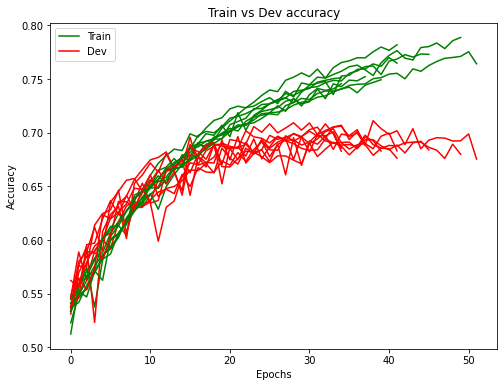

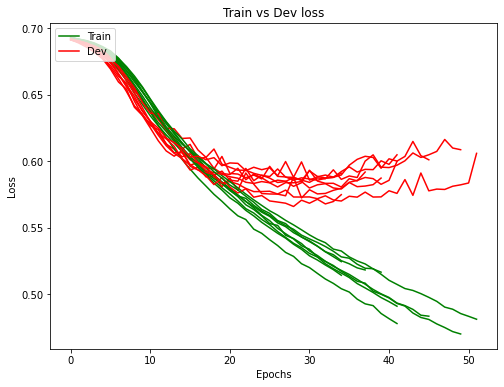

In [ ]:
def plot_logs(train_logs: list, dev_logs: list, title: str, mode: str):

    fig = plt.figure(figsize=(8,6))

    num_trials = len(train_logs)
    last_idx = num_trials - 1

    for i in range(last_idx):
      plt.plot(list(range(len(train_logs[i]))), train_logs[i], color = 'green')
      plt.plot(list(range(len(dev_logs[i]))), dev_logs[i], color = 'red')
    

    plt.plot(list(range(len(train_logs[last_idx]))), train_logs[last_idx], color = 'green', label = 'Train')
    plt.plot(list(range(len(dev_logs[last_idx]))), dev_logs[last_idx], color = 'red', label = 'Dev')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(mode)
    plt.legend(loc="upper left")

    plt.show()
    fig.savefig('{}.png'.format(title),  dpi=fig.dpi)

In [ ]:
plot_logs(train_accuracy_history, dev_accuracy_history, 'Train vs Dev accuracy', 'Accuracy')
plot_logs(train_loss_history, dev_loss_history, 'Train vs Dev loss', 'Loss')

#**Save and Load**#

In [ ]:
#load best model
'''model = WiCClassifier(
    hparams=hparams,
    device=device
    )'''
model.load_state_dict(torch.load(os.path.join(PATH_OUTPUT_FOLDER, 'state_{}.pt'.format(38)), 
                                     map_location=torch.device(device)))


<All keys matched successfully>

In [ ]:
#check that correct weight are loaded
acc = evaluate_accuracy(model, dev_dataloader, device='cuda')
acc['value']

0.7236328125

In [ ]:
#save with a specific name
#torch.save(model.state_dict(), os.path.join(PATH_OUTPUT_FOLDER, 'best_weights.pt'))

#**Predict**#

In [ ]:
#develop predict function for testing
def predict(sentence_pairs: List[Dict]) -> List[str]:
  
  predictions = []

  for d in sentence_pairs:

    sentence1 = d['sentence1']
    start1 = d['start1']
    end1 = d['end1']

    sentence2 = d['sentence2']
    start2 = d['start2']
    end2 = d['end2']

    sentences_vector = concatenate(sentence1, start1, end1, sentence2, start2, end2).to(model.device)
    out = model(sentences_vector.unsqueeze(0))
    pred = str(torch.round(out['pred'].squeeze(0)).item()==1.)
    predictions.append(pred)

  return predictions

  


In [ ]:
predict(sentence_pairs[:4])

pred:  False <class 'str'>
pred:  False <class 'str'>
pred:  True <class 'str'>
pred:  False <class 'str'>


['False', 'False', 'True', 'False']